In [178]:
import numpy as np # быстрые математические вычисления, работа с массивами
import math
import matplotlib.pyplot as plt # рисует графики, поля, траектории
from scipy.integrate import solve_ivp
from sympy import symbols, diff, lambdify

In [179]:
def f1(m1, m2, l, g):
    """
    Создает и возвращает функцию правой части для нелинейной системы
    "Маятник на тележке". Все вычисления проводятся внутри return.

    :param m1: Масса тележки.
    :param m2: Масса маятника.
    :param l: Длина маятника.
    :param g: Ускорение свободного падения.
    """


    def rhs(t, X):
        """
        X — вектор состояния [x, phi, x_dot, phi_dot]
        Возвращает dX/dt: [x_dot, phi_dot, x_ddot, phi_ddot]
        """
        x, phi, x_dot, phi_dot = X
        cos_phi = math.cos(phi)
        sin_phi = math.sin(phi)

        # | m1+m2     m2*l*cos(phi) | * | x''   | = | m2*L*sin(phi) * phi^2 |
        # | cos(phi)       l        | * | phi'' | = | g*cos(phi)            |

        DET = (m1 + m2) * l - m2 * l * (cos_phi**2)

        # Защита от деления на ноль
        if (abs(DET))<1e-6:
             print('Определитель нулевой!!!')
             return np.full(4, np.nan)

        A1 = ((m2 * l * (phi_dot**2) * sin_phi) * l - (m2 * l * cos_phi) * (-g * sin_phi))
        A2 = ((m1 + m2) * (-g * sin_phi)- (m2 * l * (phi_dot**2) * sin_phi) * cos_phi)

        # --- Возвращаемое значение --- по правилу крамера (вместо первого столбца подставляем правую часть и ищем определитель) и с правой так же
        return [
            # 1. x_dot
            x_dot,
            # 2. phi_dot
            phi_dot,
            # 3. x_ddot (Ускорение тележки)
            A1 / DET,
            # 4. phi_ddot (Угловое ускорение)
            A2 / DET
        ]

    return rhs

In [180]:
def f2(m1, m2, l, g):
    """
    Создает и возвращает функцию правой части для ЛИНЕАРИЗОВАННОЙ системы
    "Маятник на тележке" (в формате, аналогичном f1).
    :param m1: Масса тележки.
    :param m2: Масса маятника.
    :param l: Длина маятника.
    :param g: Ускорение свободного падения.
    """
    def rhs(t, X):
        """
        X — вектор состояния [x, phi, x_dot, phi_dot]
        Возвращает dX/dt: [x_dot, phi_dot, x_ddot, phi_ddot]
        """
        # Разворачиваем вектор состояния
        x, phi, x_dot, phi_dot = X
        # | m1 + m2   m2*l | * | x''  | = |   0    |
        # |    1        l  | * | phi''| = | -g*phi |
        DET = l*(m1+m2) - m2*l
        if (abs(DET))<1e-6:
             print('Определитель нулевой!!!')
             return np.full(4, np.nan)
        A1 = m2*l*g*phi
        A2 = (m1+m2)*(-g*phi)
        # --- Возвращаемое значение ---
        return [
            # 1. x_dot
            x_dot,
            # 2. phi_dot
            phi_dot,
            # 3. x_ddot
            A1 / DET,
            # 4. phi_ddot
            A2 / DET
        ]

    return rhs

In [181]:
def normal_frequencies_and_modes_cart_pendulum(m1, m2, l, g=9.81):
    """
    Вычисляет собственные частоты (omega) и нормальные моды (собственные векторы)
    для системы "Маятник на движущейся тележке".

    :param m1: Масса тележки.
    :param m2: Масса маятника.
    :param l: Длина маятника.
    :param g: Ускорение свободного падения.
    :return: (omega1, omega2), (mode1, mode2)
    """
    M = np.array([ # это левая часть линеаризованной системы
        [m1 + m2, m2 * l],
        [1, l]
    ])

    K = np.array([ # это правая часть
        [0, 0],
        [0, g]
    ])
    # MX=K, X - матрица
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.solve(M, K))

    idx = np.argsort(eigenvalues) # возвращает массив индексов, который, если использовать его для сортировки исходного массива eigenvalues, расположит его элементы по возрастанию


    omega1, omega2 = np.sqrt(np.abs(eigenvalues[idx])) # Используем abs, так как может быть -0.00000000..

    # Собственные векторы (нормальные моды)
    mode1, mode2 = eigenvectors[:, idx[0]], eigenvectors[:, idx[1]]

    # Нормализация: A_x=1 для w1, A_phi=1 для w2 (для простоты)
    # *Режим 1 (w1=0): Движение с постоянной скоростью. Выбираем x-координату опорной.*
    mode1 = mode1 / mode1[0]

    # *Режим 2 (w2>0): Колебания. Выбираем phi-координату опорной.*
    # Нормализуем так, чтобы вторая компонента (A_phi) была равна 1
    mode2 = mode2 / mode2[1]

    return (omega1, omega2), (mode1, mode2)

In [182]:
import numpy as np
# ... (предполагается, что normal_frequencies_and_modes_cart_pendulum определена)

def get_normal_mode_IC(m1, m2, l, g, mode_index, amplitude=0.1):
    """
    Определяет начальные условия (IC) для нормальных колебаний,
    используя численно рассчитанные нормальные моды.

    :param m1, m2, l, g: Параметры системы.
    :param mode_index: 1 (для omega=0) или 2 (для omega > 0).
    :param amplitude: Желаемая начальная амплитуда угла phi (для mode 2) или x (для mode 1).
    :return: Вектор начальных условий [x0, phi0, x_dot0, phi_dot0].
    """

    # 1. Рассчитываем частоты и собственные векторы
    (omega1, omega2), (mode1, mode2) = normal_frequencies_and_modes_cart_pendulum(m1, m2, l, g)

    # Все начальные скорости равны нулю для чистых колебаний
    x_dot0 = 0.0
    phi_dot0 = 0.0

    if mode_index == 1:
        x0 = amplitude
        phi0 = x0 * mode1[1]

    else:
        phi0 = amplitude
        x0 = phi0 * mode2[0]

    # Возвращаем вектор начальных условий
    return [x0, phi0, x_dot0, phi_dot0]

In [183]:
def otrisovka(f_rhs_nonlinear, f_rhs_linear, PHI_AMP, m1, m2, l, g,MODE, t_span, t_values):
    """
    Строит сравнение Нелинейной и Линеаризованной систем для Нормальной моды 2.
    (Добавлен обязательный параметр g, и изменены t, t_values на t_span, t_values)
    """

    X0_mode = get_normal_mode_IC(m1, m2, l, g, mode_index=MODE, amplitude=PHI_AMP)

    print(f"--- Запуск с phi0 = {PHI_AMP:.2f} рад ---")
    print(f"Начальные условия [x0, phi0, x_dot0, phi_dot0]: [{X0_mode[0]:.4f}, {X0_mode[1]:.4f}, 0.0, 0.0]")

    # --- Интегрирование ---
    sol_nonlinear = solve_ivp(
        fun=f_rhs_nonlinear,
        t_span=t_span,
        y0=X0_mode,
        t_eval=t_values,
        method='RK45'
    )

    sol_linear = solve_ivp(
        fun=f_rhs_linear,
        t_span=t_span,
        y0=X0_mode,
        t_eval=t_values,
        method='RK45'
    )

    # --- Построение графиков ---
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(r'Сравнение Линеаризованной и Нелинейной систем (Нормальная мода 2, $\phi_0 = $' + f'{PHI_AMP}' + ' рад)', fontsize=14)

    # График 1: Смещение тележки (x)
    axes[0].plot(sol_nonlinear.t, sol_nonlinear.y[0, :], label='Нелинейная', color='blue')
    axes[0].plot(sol_linear.t, sol_linear.y[0, :], label='Линеаризованная', linestyle='--', color='red')
    axes[0].set_ylabel('$x(t)$, м')
    axes[0].grid(True, alpha=0.5)
    axes[0].legend()

    # График 2: Угол маятника (phi)
    axes[1].plot(sol_nonlinear.t, sol_nonlinear.y[1, :], label='Нелинейная', color='blue')
    axes[1].plot(sol_linear.t, sol_linear.y[1, :], label='Линеаризованная', linestyle='--', color='red')
    axes[1].set_xlabel('$t$, с')
    axes[1].set_ylabel('$\phi(t)$, рад')
    axes[1].grid(True, alpha=0.5)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Начало симуляций для Нормальной моды 2:
--- Запуск с phi0 = 0.10 рад ---
Начальные условия [x0, phi0, x_dot0, phi_dot0]: [-0.0333, 0.1000, 0.0, 0.0]


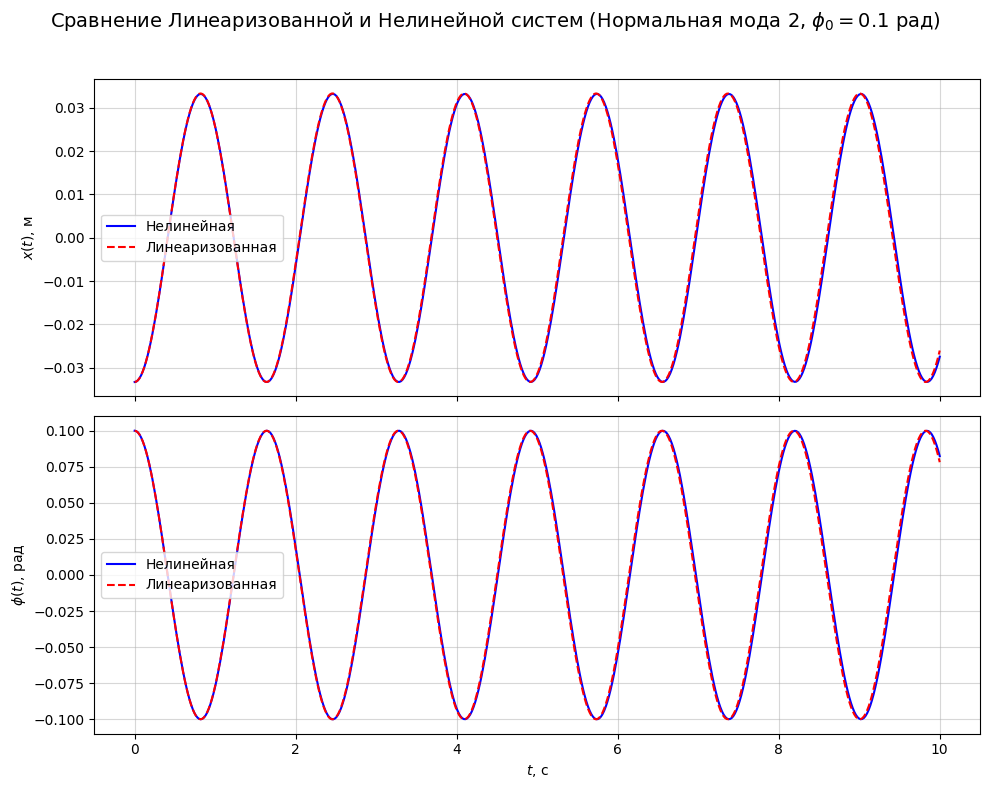

--- Запуск с phi0 = 0.20 рад ---
Начальные условия [x0, phi0, x_dot0, phi_dot0]: [-0.0667, 0.2000, 0.0, 0.0]


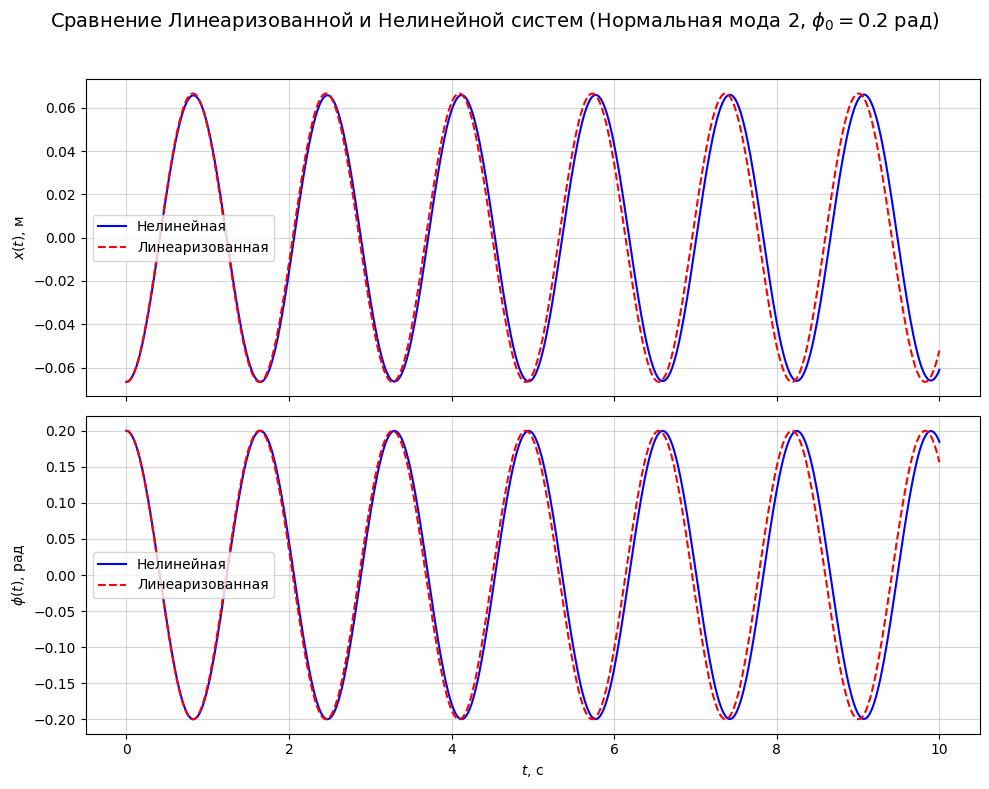

--- Запуск с phi0 = 0.40 рад ---
Начальные условия [x0, phi0, x_dot0, phi_dot0]: [-0.1333, 0.4000, 0.0, 0.0]


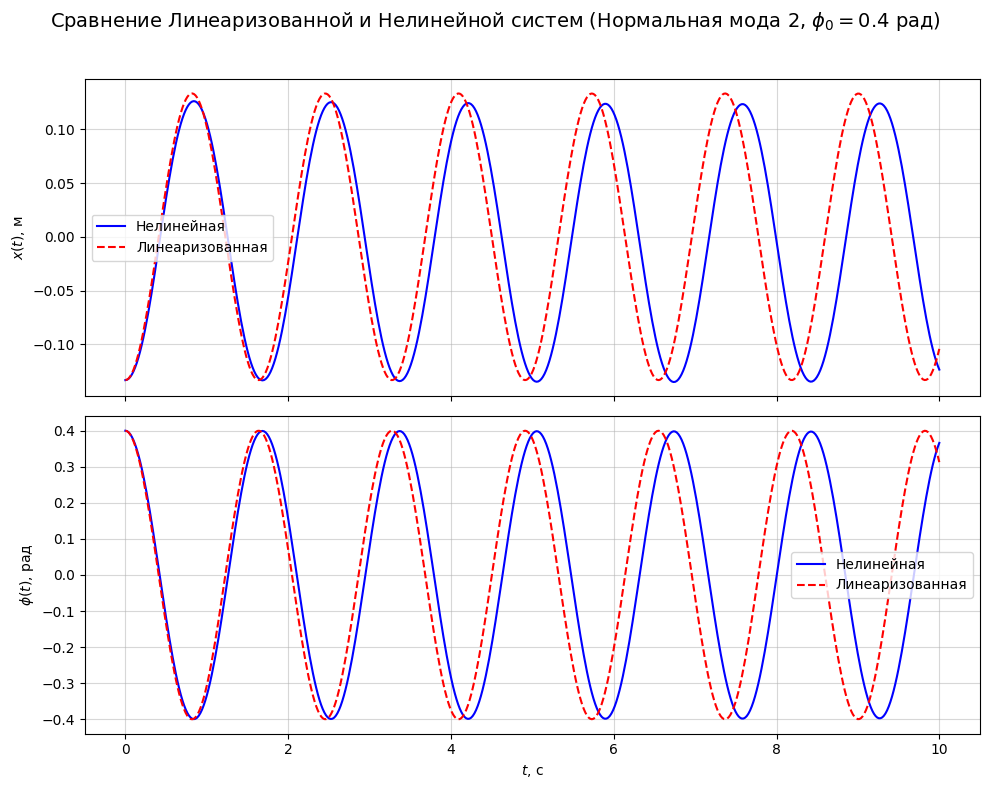

--- Запуск с phi0 = 0.50 рад ---
Начальные условия [x0, phi0, x_dot0, phi_dot0]: [-0.1667, 0.5000, 0.0, 0.0]


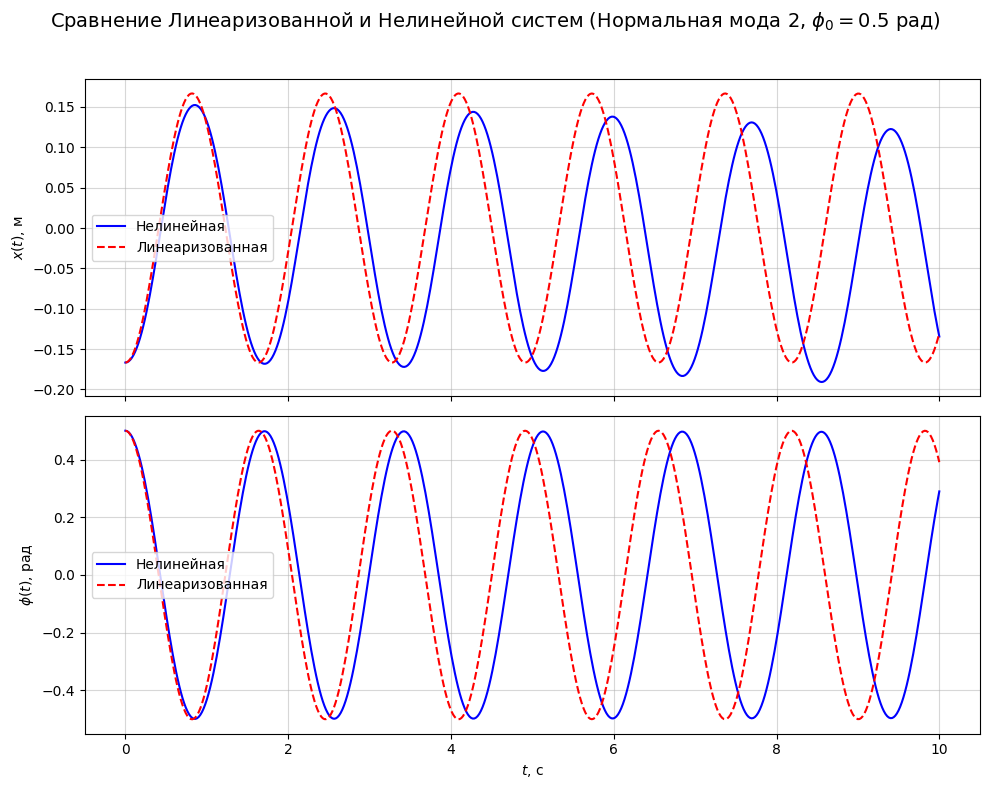

--- Запуск с phi0 = 0.60 рад ---
Начальные условия [x0, phi0, x_dot0, phi_dot0]: [-0.2000, 0.6000, 0.0, 0.0]


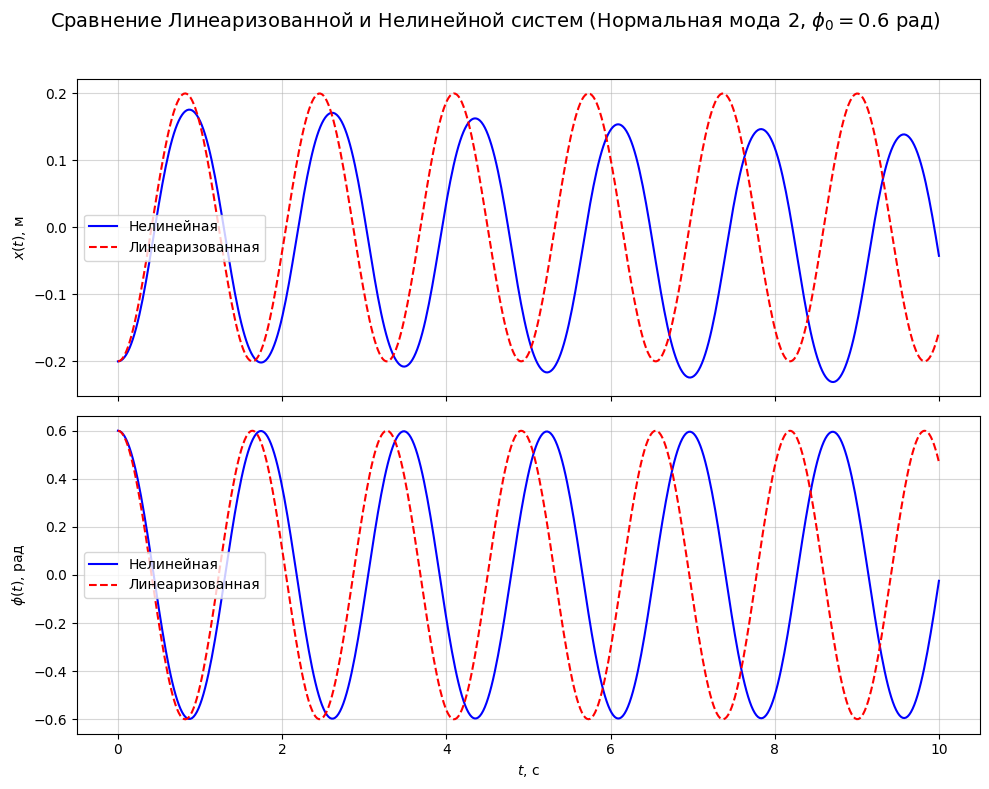

Все симуляции завершены.


In [184]:
m1 = 1.0  # Масса тележки, кг
m2 = 0.5  # Масса маятника, кг
l = 1.0   # Длина маятника, м
g = 9.81  # Ускорение свободного падения, м/с^2

t_span = [0, 10]  # Время симуляции (от 0 до 10 секунд)
N_POINTS = 500    # Количество точек для построения графиков
t_values = np.linspace(t_span[0], t_span[1], N_POINTS)

# Получение функций правой части
f_rhs_nonlinear = f1(m1, m2, l, g)
f_rhs_linear = f2(m1, m2, l, g)
MODE = 2
# Запуск симуляций с разными амплитудами
print("Начало симуляций для Нормальной моды 2:")
for phi_amp in [0.1, 0.2, 0.4, 0.5, 0.6]:
    otrisovka(f_rhs_nonlinear, f_rhs_linear, phi_amp, m1, m2, l, g,MODE, t_span, t_values)

print("Все симуляции завершены.")

--- Запуск с phi0 = 0.10 рад ---
Начальные условия [x0, phi0, x_dot0, phi_dot0]: [0.1000, 0.0000, 0.0, 0.0]


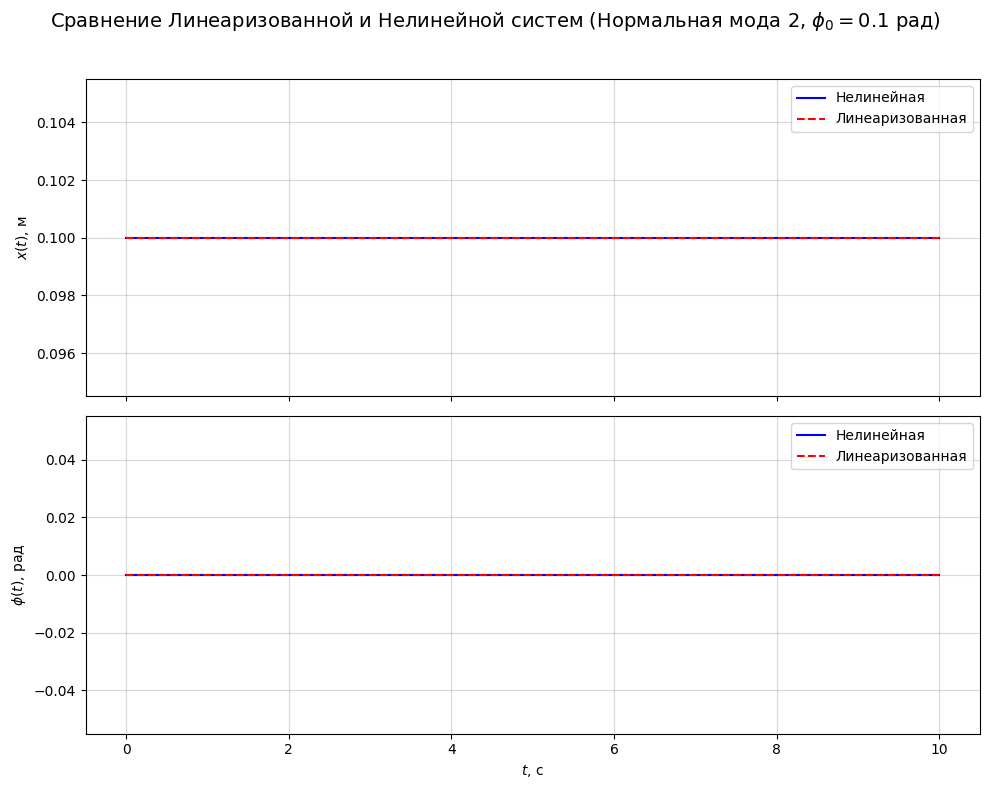

--- Тест Моды 1 ($\omega pprox 0$) ---
Начальные условия (X0) для X_AMP=0.1 м: [0.1, np.float64(0.0), 0.0, 0.0]


In [185]:
# --- Параметры (остаются прежними) ---
m1 = 1.0; m2 = 0.5; l = 1.0; g = 9.81
t_span = [0, 10]
N_POINTS = 500
t_values = np.linspace(t_span[0], t_span[1], N_POINTS)

# --- Инициализация функций (f1, f2) ---
# Предполагается, что f1 и f2 определены
f_rhs_nonlinear = f1(m1, m2, l, g)
f_rhs_linear = f2(m1, m2, l, g)

# --- Получение начальных условий для НОРМАЛЬНОЙ МОДЫ 1 ---
MODE = 1
# Амплитуда задается для x (смещение тележки)
X_AMP = 0.1
X0_mode1 = get_normal_mode_IC(m1, m2, l, g, MODE, X_AMP)
otrisovka(f_rhs_nonlinear, f_rhs_linear, X_AMP, m1, m2, l, g, MODE, t_span, t_values)
print(f"--- Тест Моды 1 ($\omega \approx 0$) ---")
print(f"Начальные условия (X0) для X_AMP={X_AMP} м: {X0_mode1}")

# Примечание: phi0 должно быть очень маленьким или нулевым